In [1]:
import pandas as pd
import numpy as np
import pycountry
from scipy.optimize import least_squares
import random
import statsmodels
from scipy.optimize import minimize
from scipy.optimize import fsolve
from pandas.core import datetools
import statsmodels.api as sm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from collections import defaultdict
from math import pi, e

/home/sara/myenv/lib64/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  if __name__ == '__main__':


In [2]:
resident_foreigners_norm = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/resident_foreigners_norm.csv")

#province_capitals = ['Ancona', "Valle d'Aosta / Vallée d'Aoste", "L'Aquila", 'Bari', 'Bologna', 'Cagliari', 'Campobasso', 'Catanzaro', 'Firenze', 'Genova', 'Milano', 'Napoli', 'Palermo', 'Perugia', 'Potenza', 'Roma', 'Torino', 'Trento', 'Trieste', 'Venezia']
# Untill 2011 - in 2011 change
#years = list(range(2004, 2008))

In [3]:
resident_foreigners_norm.head()

,Province,Country,Year,Gender,Value
0,Biella,AND,2005,male,1
1,Biella,AND,2005,female,0
2,Novara,AND,2005,male,0
3,Novara,AND,2005,female,2
4,Alessandria,AND,2017,male,0


In [4]:
'''regions = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/regioni.csv")
regions_info = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/region_info.csv")

prov_info = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/prov_cap_info.csv")

mezzogiorno = {'Abruzzo': 1, 'Lazio': 0, 'Umbria': 0, 'Provincia Autonoma Trento': 0, 
               'Friuli-Venezia Giulia': 0, 'Molise': 1, 'Calabria': 1, 
               "Valle d'Aosta / Vallée d'Aoste": 0, 'Lombardia': 0, 'Liguria': 0, 
               'Emilia-Romagna': 0, 'Sicilia': 1, 
               'Provincia Autonoma Bolzano / Bozen': 0, 'Puglia': 1, 'Campania': 1, 
               'Piemonte': 0, 'Toscana': 0, 'Sardegna': 1, 'Marche': 0, 
               'Basilicata': 1, 'Veneto': 0}'''

'regions = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/regioni.csv")\nregions_info = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/region_info.csv")\n\nprov_info = pd.read_table("/home/sara/Documents/Immigration/Shared_statistics/Data_final/prov_cap_info.csv")\n\nmezzogiorno = {\'Abruzzo\': 1, \'Lazio\': 0, \'Umbria\': 0, \'Provincia Autonoma Trento\': 0, \n               \'Friuli-Venezia Giulia\': 0, \'Molise\': 1, \'Calabria\': 1, \n               "Valle d\'Aosta / Vallée d\'Aoste": 0, \'Lombardia\': 0, \'Liguria\': 0, \n               \'Emilia-Romagna\': 0, \'Sicilia\': 1, \n               \'Provincia Autonoma Bolzano / Bozen\': 0, \'Puglia\': 1, \'Campania\': 1, \n               \'Piemonte\': 0, \'Toscana\': 0, \'Sardegna\': 1, \'Marche\': 0, \n               \'Basilicata\': 1, \'Veneto\': 0}'

In [5]:
'''x_df = pd.DataFrame()
x_df = prov_info[["Prov Capitals", "Area", "Dens"]].copy()
# Logarithmic transformation
x_df["Area"] = np.log(x_df["Area"])
x_df["Dens"] = np.log(x_df["Dens"])
x_df["Mezzogiorno"] = [mezzogiorno[regions[regions["Provincia"] == i]["Regione"].values[0]] for i in x_df["Prov Capitals"].values]'''

'x_df = pd.DataFrame()\nx_df = prov_info[["Prov Capitals", "Area", "Dens"]].copy()\n# Logarithmic transformation\nx_df["Area"] = np.log(x_df["Area"])\nx_df["Dens"] = np.log(x_df["Dens"])\nx_df["Mezzogiorno"] = [mezzogiorno[regions[regions["Provincia"] == i]["Regione"].values[0]] for i in x_df["Prov Capitals"].values]'

In [6]:
#x_df.head()

In [17]:
# Get the foreigners stock value
def n_it(data_, i, t):
    return(data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0])

In [8]:
'''# Fill with 0 missing values
def missing_values(data_, times, territories):
    for i in territories:
        for t in times:
            try:
                temp = data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0]
            except IndexError:
                data_ = data_.append({"Province": i, "Year": t, "Value": 0}, ignore_index=True)
    return(data_)'''

'# Fill with 0 missing values\ndef missing_values(data_, times, territories):\n    for i in territories:\n        for t in times:\n            try:\n                temp = data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0]\n            except IndexError:\n                data_ = data_.append({"Province": i, "Year": t, "Value": 0}, ignore_index=True)\n    return(data_)'

In [9]:
def count(data_):
    count_obj = defaultdict(lambda: 0)
    for i in data_:
        count_obj[i] += 1
    return(count_obj)

In [10]:
# Do not consider provinces with missing values (0 immigrants) for more than two years (>= 3) (My Assumption!)
def not_including(data_, times, territories):
    temp_not_in = list()
    for i in territories:
        for t in times:
            try:
                temp = data_[(data_["Province"] == i) & (data_["Year"] == t)]["Value"].values[0]
            except IndexError:
                temp_not_in.append(i)
    not_in_count = count(temp_not_in)
    not_in = [k for k, v in not_in_count.items() if v >= 3]
    return(not_in)

In [11]:
# Reference province
I = "Roma"

In [12]:
data = resident_foreigners_norm.copy()
data = data.groupby(["Province", "Country", "Year"], as_index=False).sum()

In [13]:
data.head()

,Province,Country,Year,Value
0,Agrigento,AFG,2008,2
1,Agrigento,AFG,2009,12
2,Agrigento,AFG,2010,51
3,Agrigento,AFG,2011,35
4,Agrigento,AFG,2012,21


## Step I

In [14]:
# Define the normal regression model

def stepI(param, data_, time, I, territories):
    log_lik = 0
    
    beta = param[0]
    a = param[1:]
    
    for i in territories:
        for t in time[1:]:
            log_lik += (np.log(n_it(data_, i, t)/n_it(data_, I, t)) - beta*(np.log(n_it(data_, i, t-1)/n_it(data_, I, t-1))) - a[territories.index(i)])**2 

    return(log_lik)

## Step II

In [15]:
def stepII(theta, a, x_, I, territories):
    log_lik = 0
    x_I = x_[x_["Prov Capitals"] == I][["Area", "Dens", "Mezzogiorno"]].values
    
    for i in territories:
        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].values
        log_lik += (a[territories.index(i)] - np.dot(np.subtract(x_i, x_I), theta))**2
    return(log_lik)

# Run the different models for the different origin country

In [16]:
def run_model(data_all, country, times, I, x_, territories = None):
    if not territories:
        territories = list(set(data_all["Province"]))
        
    #territories = list(set(data_all["Province"]))

    data_all = data_all[data_all["Year"].isin(times)]
    missing_territories = not_including(data_all, times, territories)
    territories = [i for i in territories if i not in missing_territories]
    data_all = data_all[data_all["Province"].isin(territories)]

    # Also the stock in the refered province is needed in the optimization 
    data_ = data_all[data_all["Country"] == pycountry.countries.get(name=country).alpha_3]
    del data_["Country"]

    # Do not include the refered province in the optimization 
    territories = [p for p in territories if p != I]
    # Handle missing values
    #data_ = missing_values(data_, times, territories)

    print("---------- Step I ----------")
    initial_time = datetime.datetime.now()
    print ("Current time: " + str(initial_time.strftime('%H:%M:%S') ))

    #param_init = np.random.uniform(0, 1, len(territories)+1)
    param_init = [0 for i in range(len(territories)+1)]
    res_stepI =  minimize(stepI, param_init, args = (data_, times, I, territories), method='CG')
    print(res_stepI.message)
    
    final_time = datetime.datetime.now() 
    print ("Current time: " + str(final_time.strftime('%H:%M:%S')))
    print("Computational time: " + str((final_time - initial_time)))
    
    # Step I results and validation
    beta_hat = res_stepI.x[0]
    a_hat = res_stepI.x[1:]
    y_hat = []
    y = []
    for i in territories:
        time_invariant = a_hat[territories.index(i)]
        for t in times[1:]:
            y.append(np.log(n_it(data_, i, t)/n_it(data_, I, t)))
            y_hat.append(beta_hat*(np.log(n_it(data_, i, t-1)/n_it(data_, I, t-1))) + time_invariant)
            
    y_mean = np.mean(y)

    R2 = 1 - sum(np.subtract(y, y_hat)**2) / sum((y - y_mean)**2)
    # Equivalently: 1 - (res_stepI.fun / sum((y - y_mean)**2))
    #print(R2)
    print("The R2 score from the step I is: %f" %R2)
    
    return(beta_hat, a_hat)
'''    
    print("---------- Step II ----------")
    
    initial_time = datetime.datetime.now()
    print ("Current time: " + str(initial_time.strftime('%H:%M:%S') ))

    param_init = [0 for i in range(len(x_.columns)-1)]
    #param_init = np.random.uniform(0, 1, len(x_df.columns)-1)
    res_stepII =  minimize(stepII, param_init, args = (a_hat, x_, I, territories), method='CG')
    #print(model_I([b, a], data_rou), b, a)
    #print(res_stepII.x)
    print(res_stepII.message)
    #print(res_stepII.fun)
    final_time = datetime.datetime.now() 
    print ("Current time: " + str(final_time.strftime('%H:%M:%S')))
    print("Computational time: " + str((final_time - initial_time)))
    
    # Step II results and validation
    theta_hat = res_stepII.x
    x_I = x_[x_["Prov Capitals"] == I][["Area", "Dens", "Mezzogiorno"]].values
    y_hat = []
    #y = []
    for i in territories:
        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].values
        time_invariant = np.dot(np.subtract(x_i, x_I), theta_hat)
        for t in times[1:]:
            #y.append(np.log(n_it(data_, i, t)/n_it(data_, I, t)))
            y_hat.append((beta_hat*(np.log(n_it(data_, i, t-1)/n_it(data_, I, t-1))) + time_invariant)[0])
            
    #y_mean = np.mean(y)
    R2 = 1 - sum(np.subtract(y, y_hat)**2) / sum((y - y_mean)**2)
    #print(R2)
    print("The final R2 score is: %f" %R2)
    
    n = len(y)
    k = len(x_.columns)-1
    R2_adj = 1 - (1 - R2)*((n - 1)/(n - k -1))
    print("The final Adjusted R2 score is: %f" %R2_adj)
    
    return(beta_hat, theta_hat)'''

'    \n    print("---------- Step II ----------")\n    \n    initial_time = datetime.datetime.now()\n    print ("Current time: " + str(initial_time.strftime(\'%H:%M:%S\') ))\n\n    param_init = [0 for i in range(len(x_.columns)-1)]\n    #param_init = np.random.uniform(0, 1, len(x_df.columns)-1)\n    res_stepII =  minimize(stepII, param_init, args = (a_hat, x_, I, territories), method=\'CG\')\n    #print(model_I([b, a], data_rou), b, a)\n    #print(res_stepII.x)\n    print(res_stepII.message)\n    #print(res_stepII.fun)\n    final_time = datetime.datetime.now() \n    print ("Current time: " + str(final_time.strftime(\'%H:%M:%S\')))\n    print("Computational time: " + str((final_time - initial_time)))\n    \n    # Step II results and validation\n    theta_hat = res_stepII.x\n    x_I = x_[x_["Prov Capitals"] == I][["Area", "Dens", "Mezzogiorno"]].values\n    y_hat = []\n    #y = []\n    for i in territories:\n        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].valu

In [18]:
res_rou = run_model(data, "Romania", list(range(2004, 2008)), I, x_ = [])

---------- Step I ----------
Current time: 11:21:39


KeyboardInterrupt: 

In [28]:
print("Beta parameter: %f" %res_rou[0])
#print("Theta parameter: %s %s %s" %tuple(res_rou[1]))

Beta parameter: 0.123598


In [34]:
res_alb = run_model(data, "Albania", list(range(2004, 2008)), I, x_ = [])

---------- Step I ----------
Current time: 13:51:08
Optimization terminated successfully.
Current time: 14:59:30
Computational time: 1:08:22.553267
The R2 score from the step I is: 0.997498


In [35]:
print("Beta parameter: %f" %res_alb[0])
#print("Theta parameter: %s %s %s" %tuple(res_alb[1]))

Beta parameter: 0.870678


In [36]:
res_alb = run_model(data, "China", list(range(2004, 2008)), I, x_ = [])

---------- Step I ----------
Current time: 16:42:22
Optimization terminated successfully.
Current time: 19:29:40
Computational time: 2:47:17.935325
The R2 score from the step I is: 0.990575


In [38]:
print("Beta parameter: %f" %res_alb[0])
#print("Theta parameter: %s %s %s" %tuple(res_mar[1]))

Beta parameter: 0.019565


In [32]:
res_chi = run_model(data, "China", years, province_capitals, I, x_df)

print("Beta parameter: %f" %res_chi[0])
print("Theta parameter: %s %s %s" %tuple(res_chi[1]))

---------- Step I ----------
Current time: 12:31:50
Optimization terminated successfully.
Current time: 12:33:41
Computational time: 0:01:51.242071
The R2 score from the step I is: 0.994859
---------- Step II ----------
Current time: 12:33:42
Optimization terminated successfully.
Current time: 12:33:42
Computational time: 0:00:00.902617
The final R2 score is: 0.842854
The final Adjusted R2 score is: 0.834435
Beta parameter: 0.015020
Theta parameter: 0.556299976834 1.09672875358 -0.933305303198


In [31]:
def real_vs_prediction(res_, data_, time, x_, country):
    beta_hat = res_[0]
    theta_hat = res_[1]
    prediction = defaultdict(list)
    real = defaultdict(list)
    x_I = x_[x_["Prov Capitals"] == I][["Area", "Dens", "Mezzogiorno"]].values

    for i in province_capitals:
        x_i = x_[x_["Prov Capitals"] == i][["Area", "Dens", "Mezzogiorno"]].values
        time_invariant = np.dot(np.subtract(x_i, x_I), theta_hat)
        for t in time[1:]:
            real[t].append((n_it(data_, i, t)))
            prediction[t].append(e**((beta_hat*(np.log(n_it(data_, i, t-1)/n_it(data_, I, t-1))) + np.log(n_it(data_, I, t)) + time_invariant)[0]))

            sns.set_style("whitegrid")
    sns.set_context({"figure.figsize": (10, 8)})

    for k, v in real.items():
        legend = []
        sns.pointplot(y = v, x = province_capitals, label= "Real")
        legend.append(mlines.Line2D([], [], markersize=15, label="Real"))
        sns.pointplot(y = prediction[k], x = province_capitals, label= "Prediction", color = "red")
        legend.append(mlines.Line2D([], [], color="red", markersize=15, label="Prediction"))

        plt.xticks(rotation=90)
        sns.despine(left=True)
        plt.xlabel("Province Capitals", fontsize=12)
        plt.ylabel("Abs Population", fontsize=12)
        plt.legend(handles = legend, prop={'size':14}, loc='upper right', bbox_to_anchor=(1.25, 1.), ncol=1)
        plt.title("%s prediction - %d" %(country, k), fontsize = 16)
        plt.show()

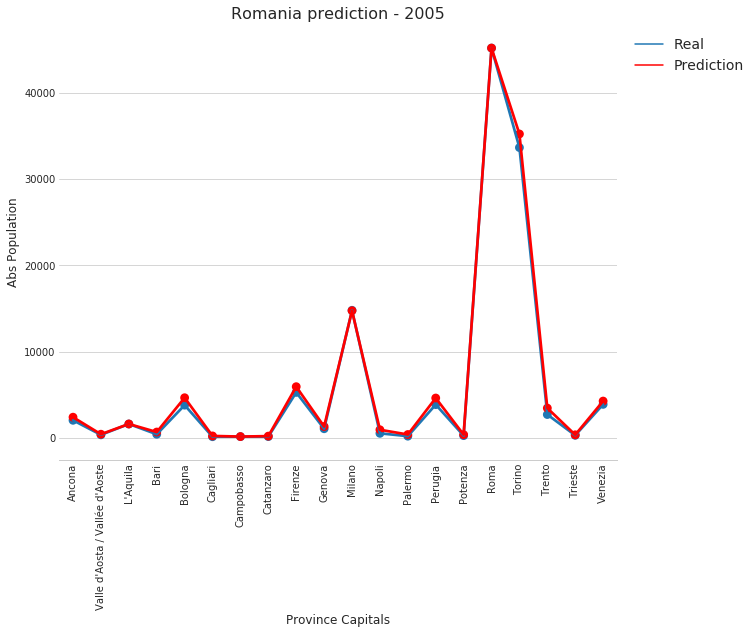

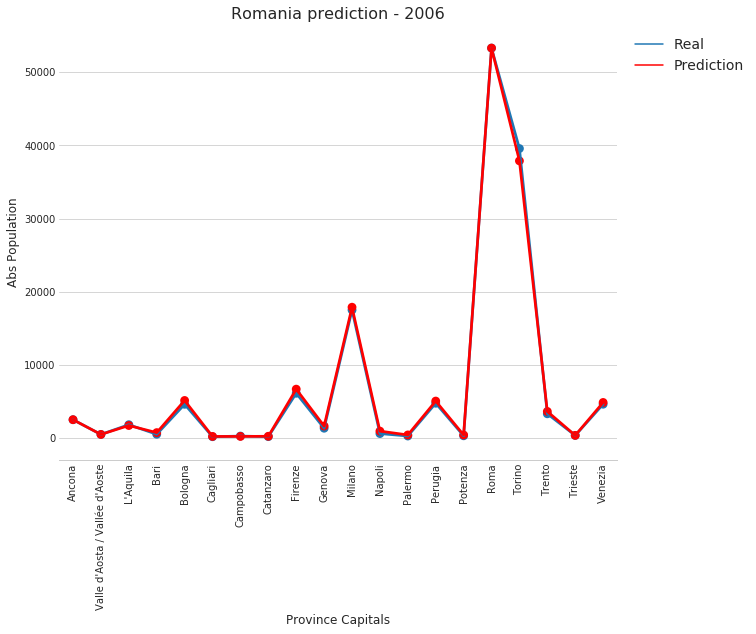

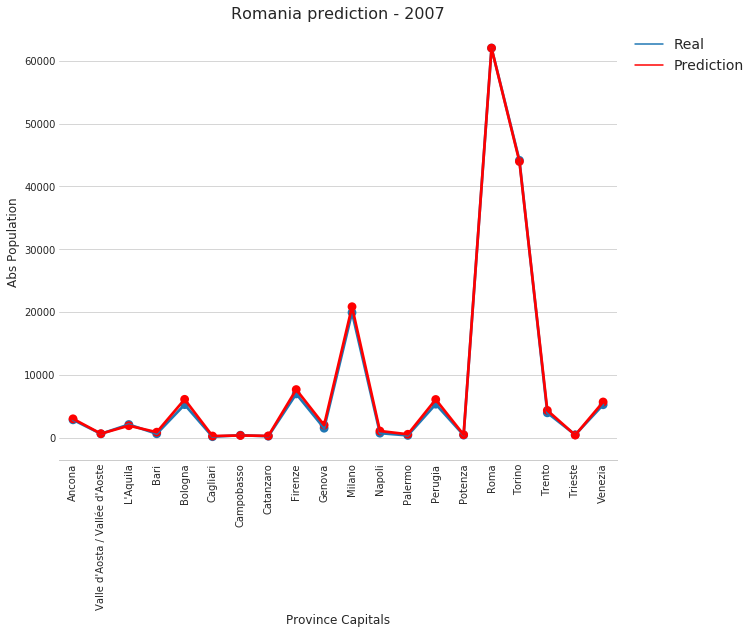

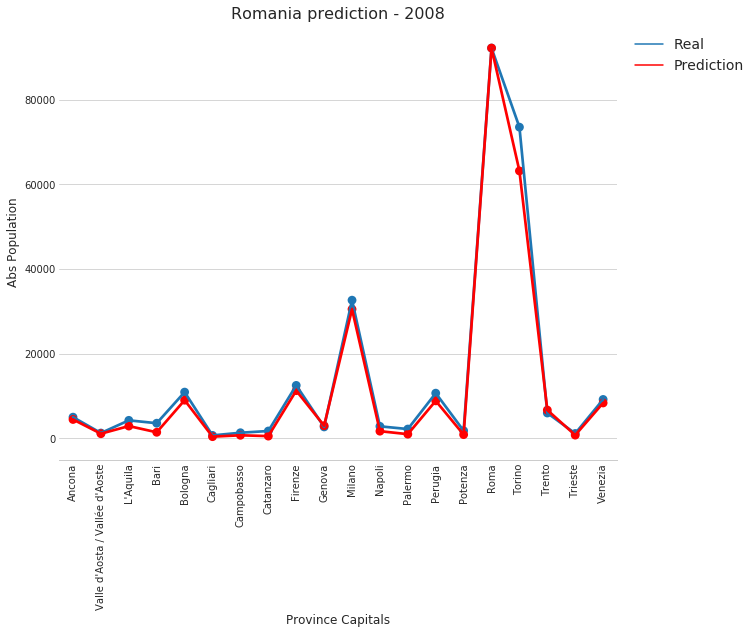

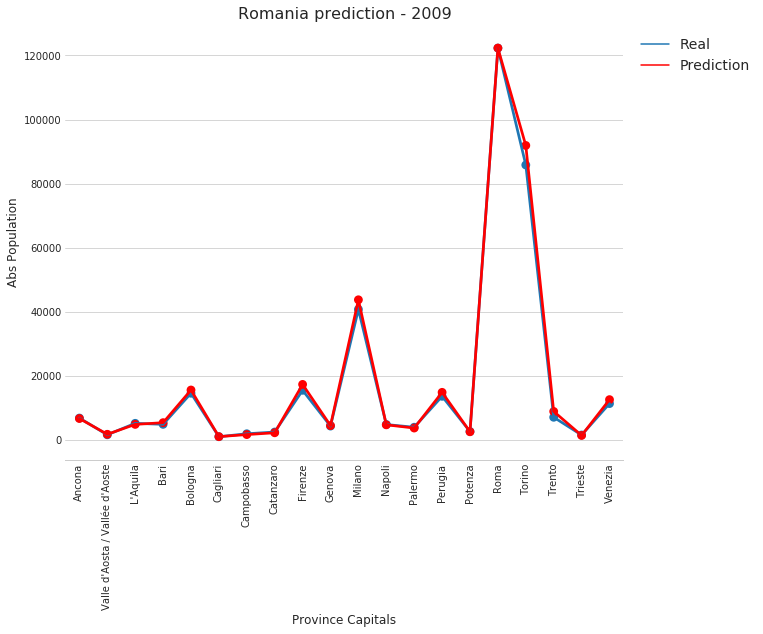

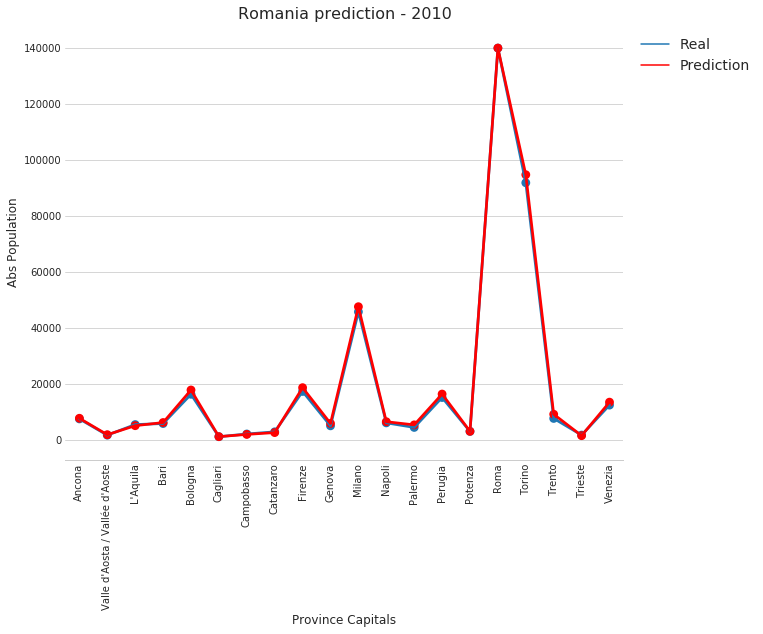

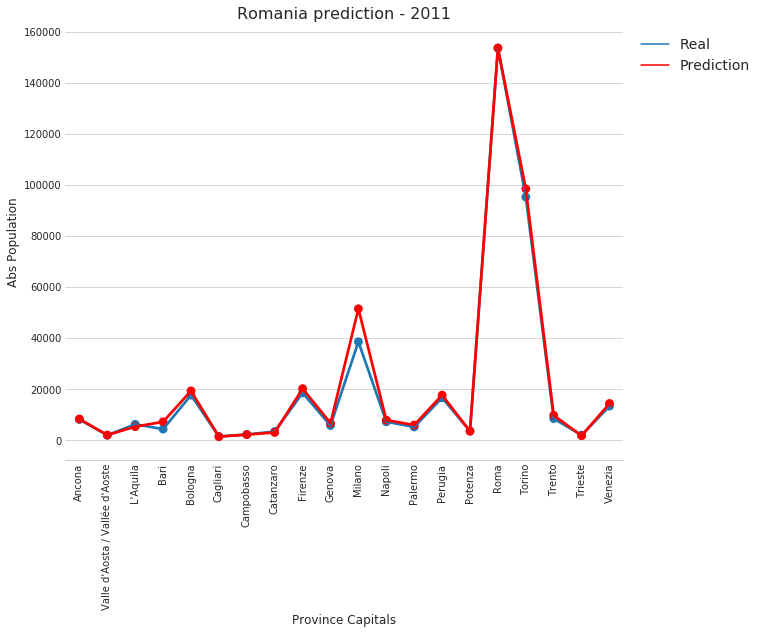

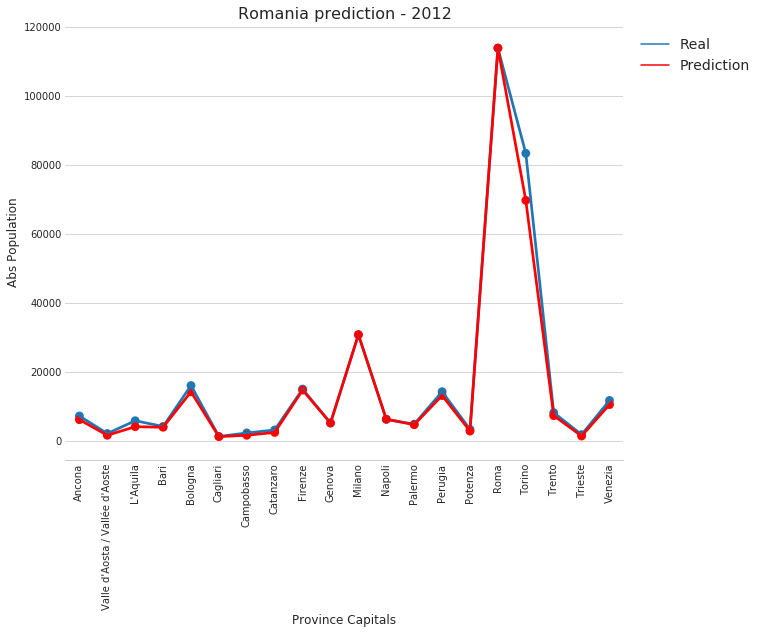

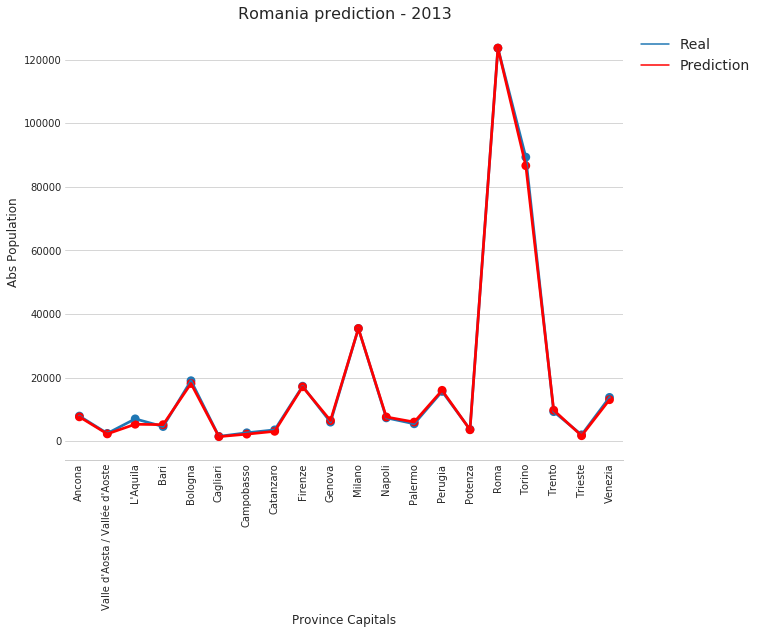

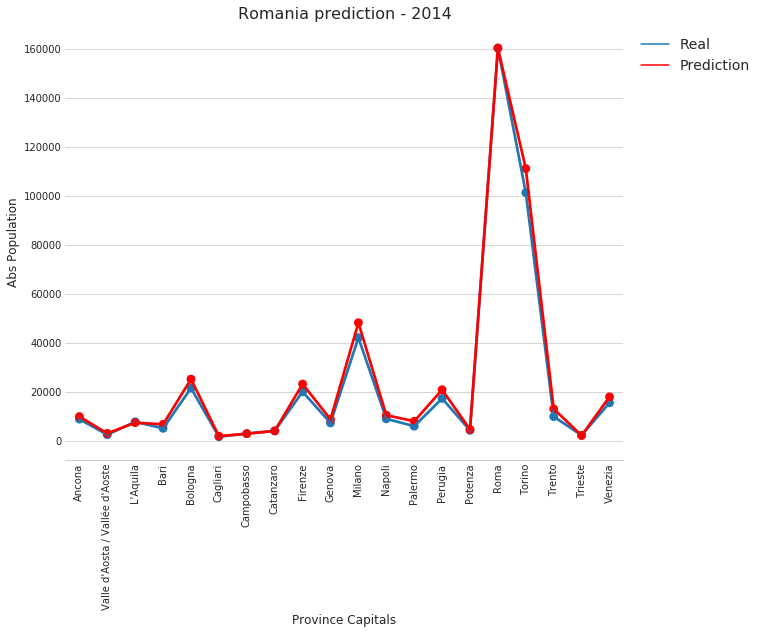

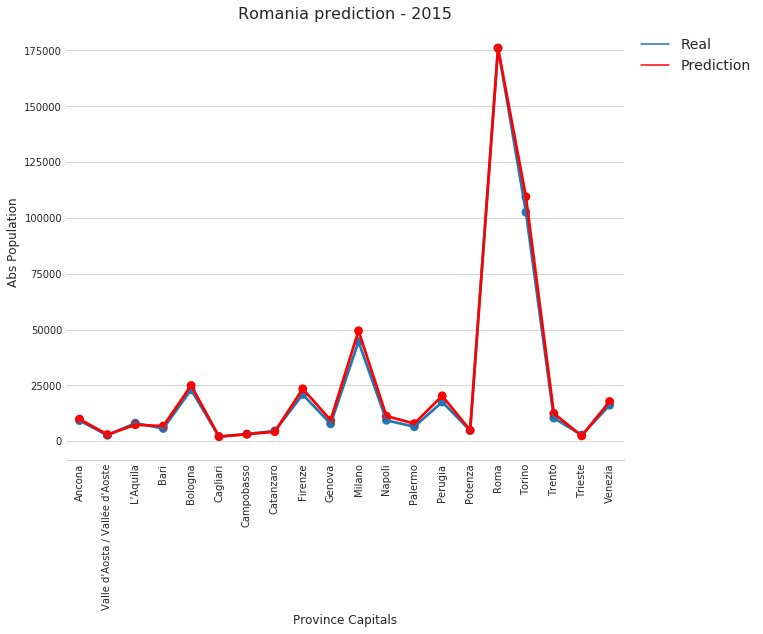

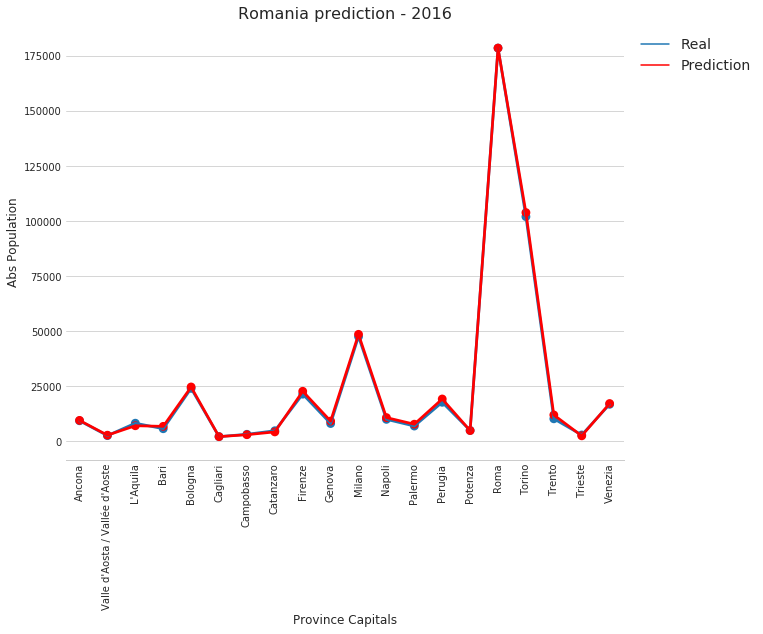

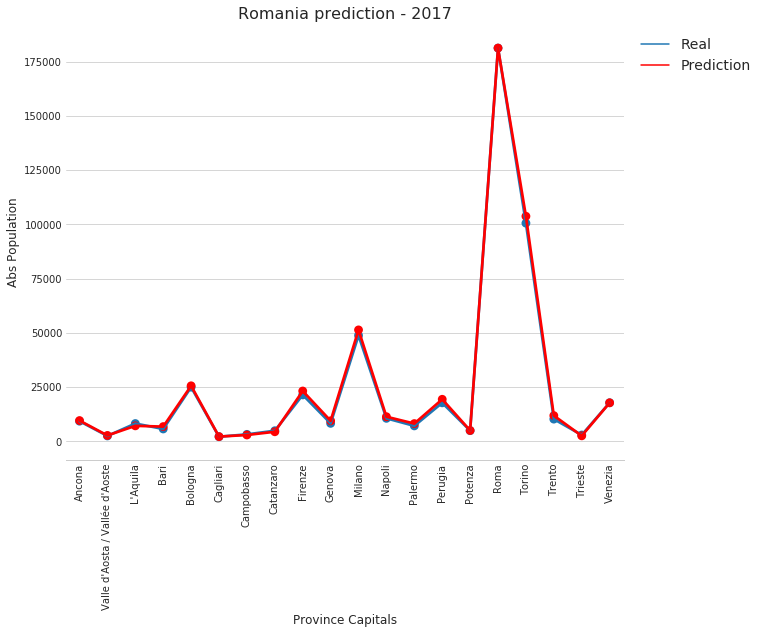

In [26]:
real_vs_prediction(res_rou, data_rou, years, x_df, "Romania")

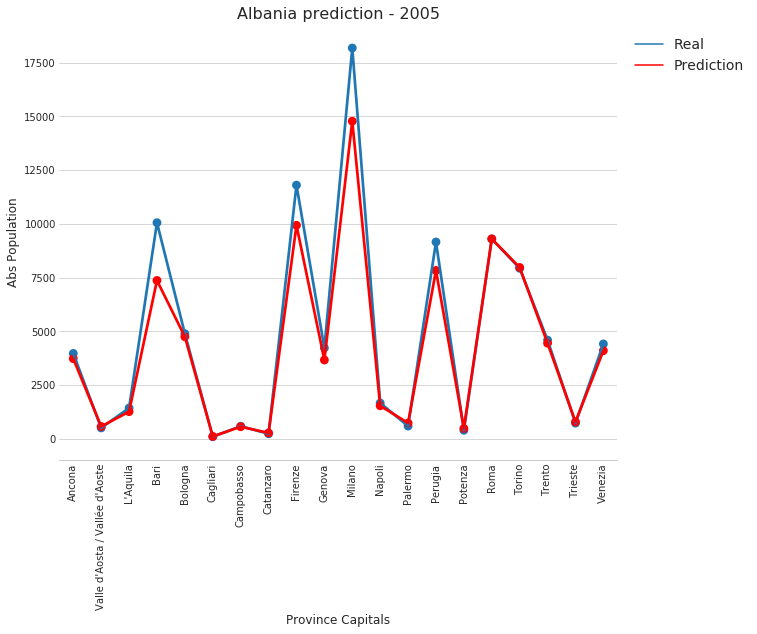

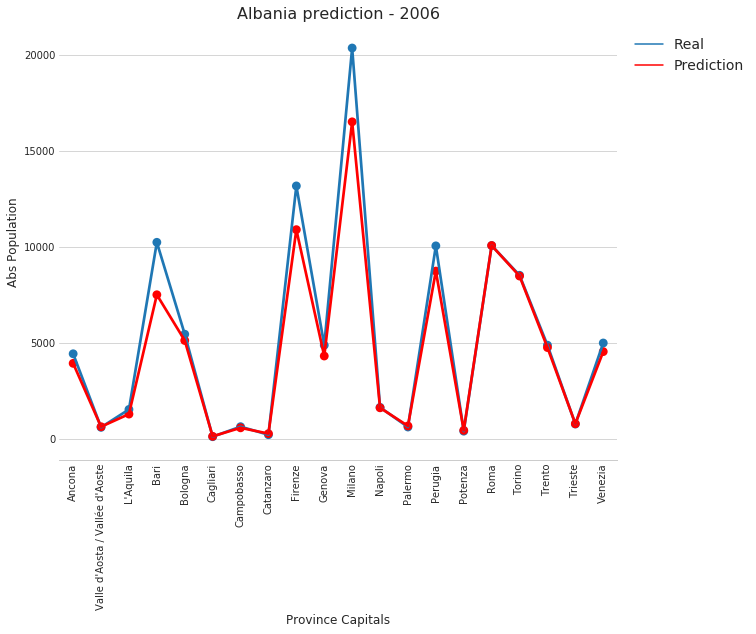

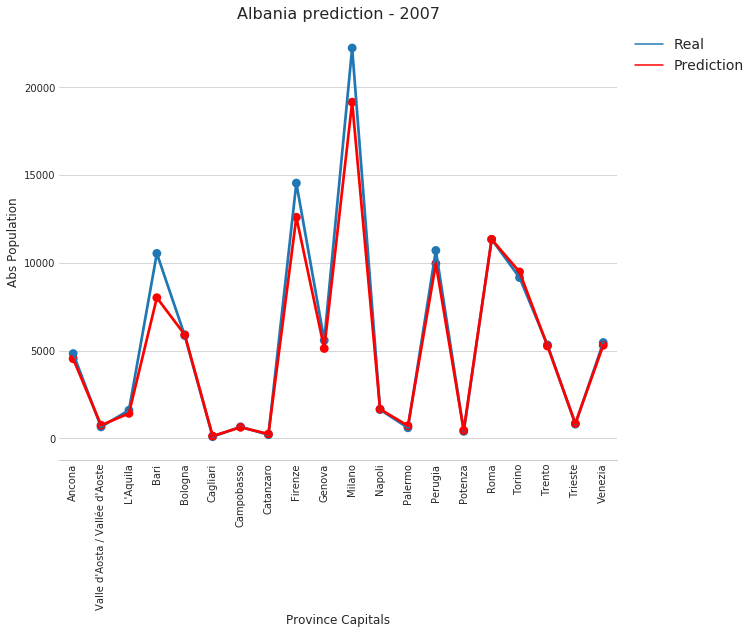

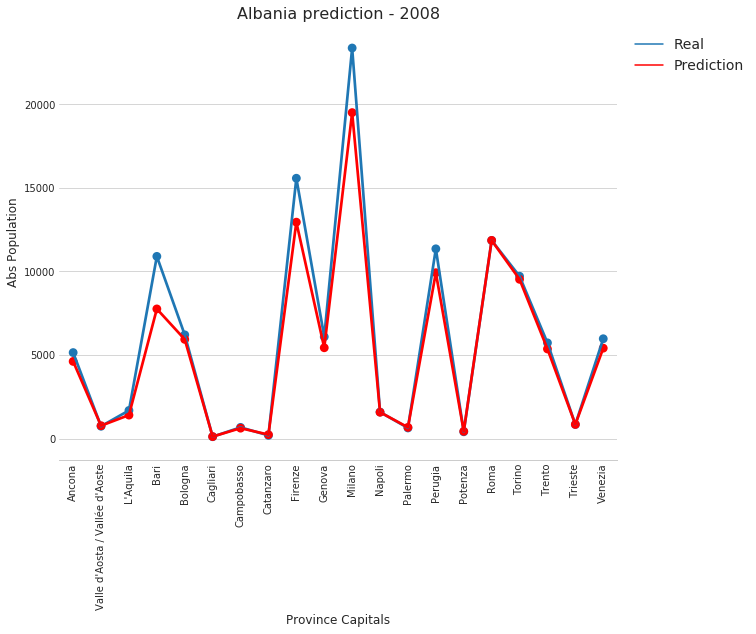

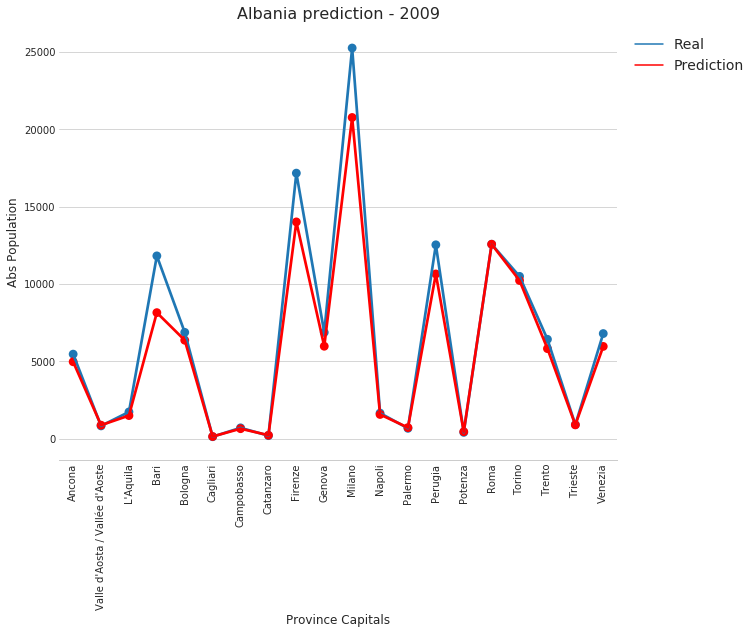

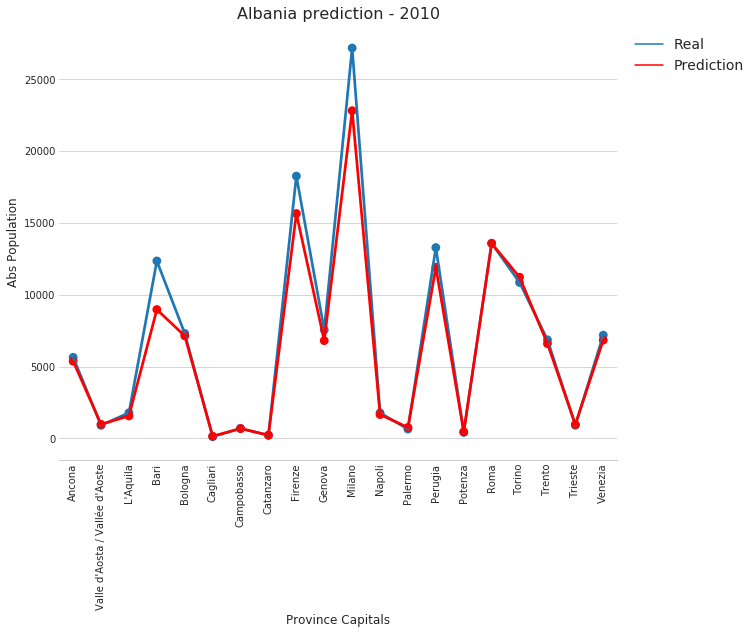

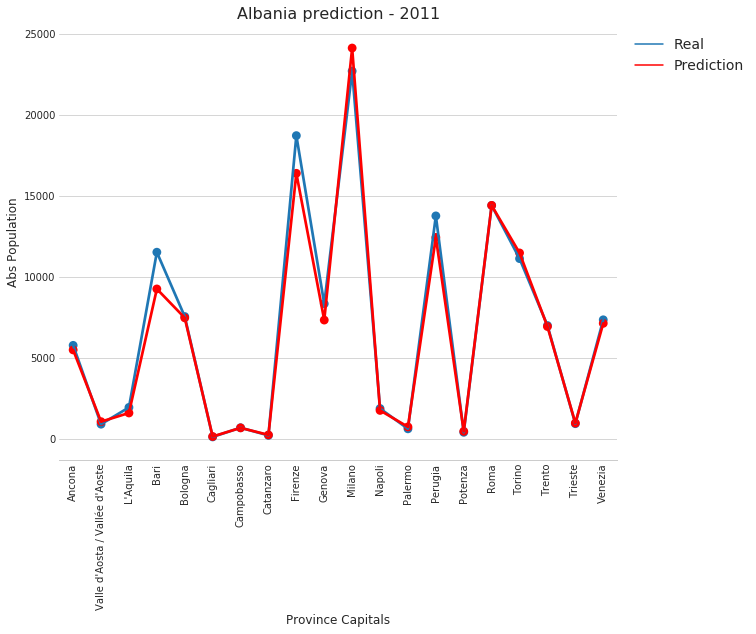

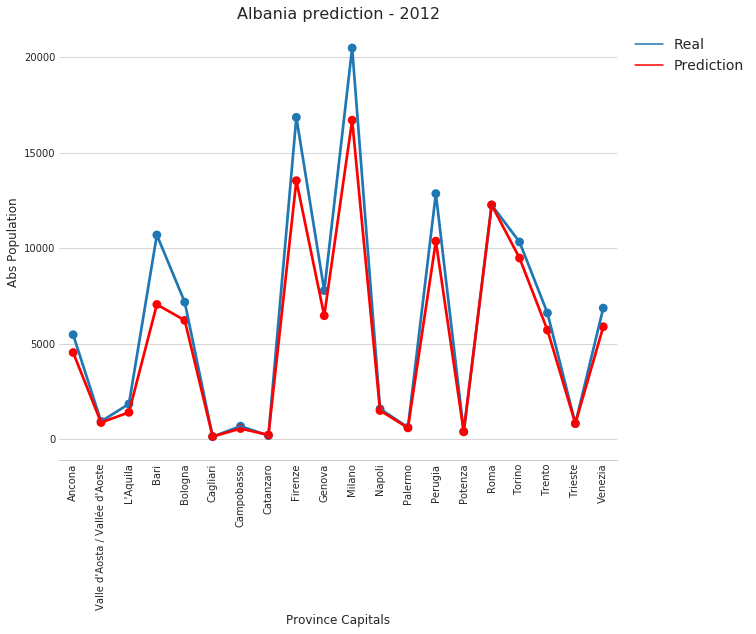

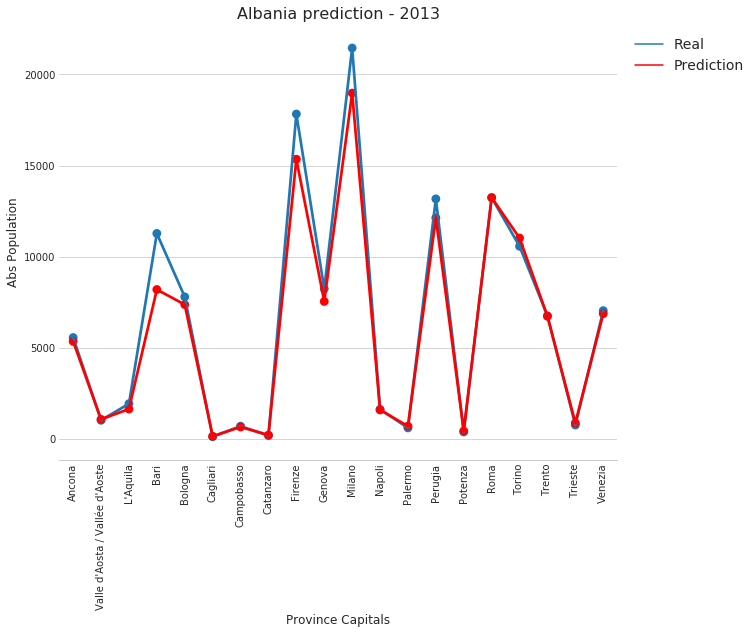

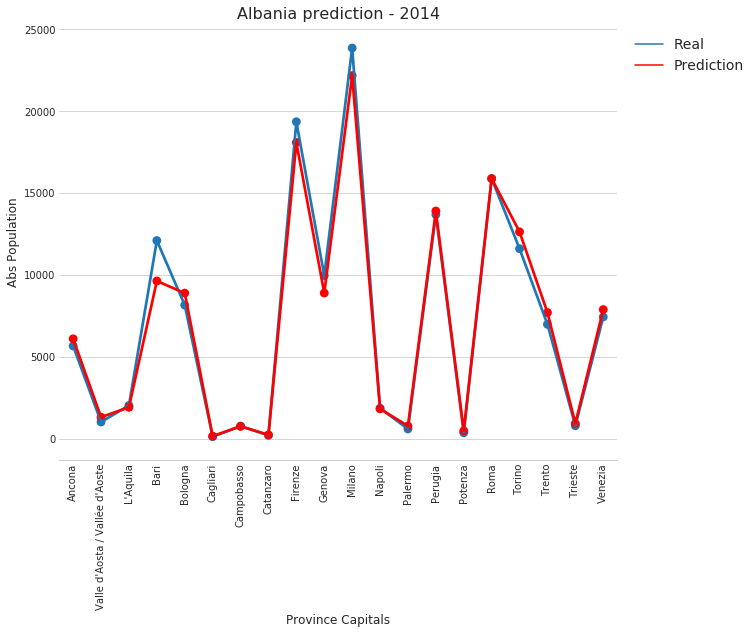

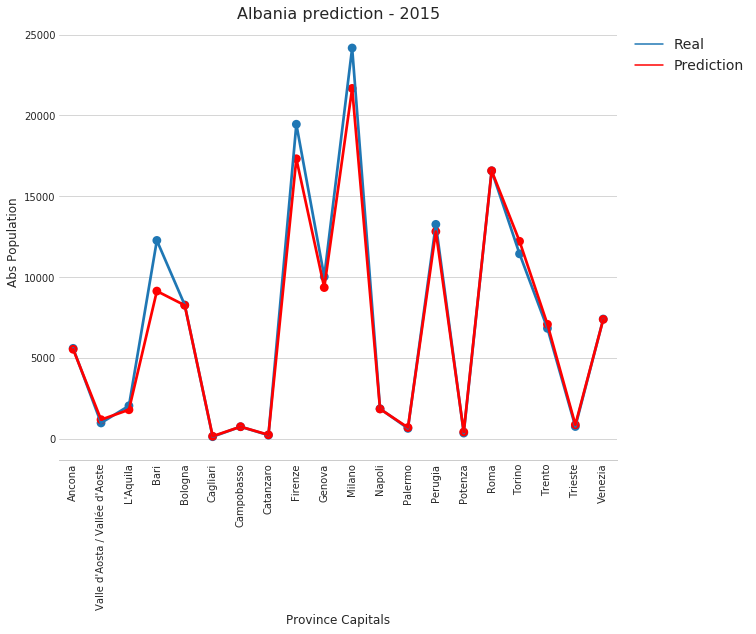

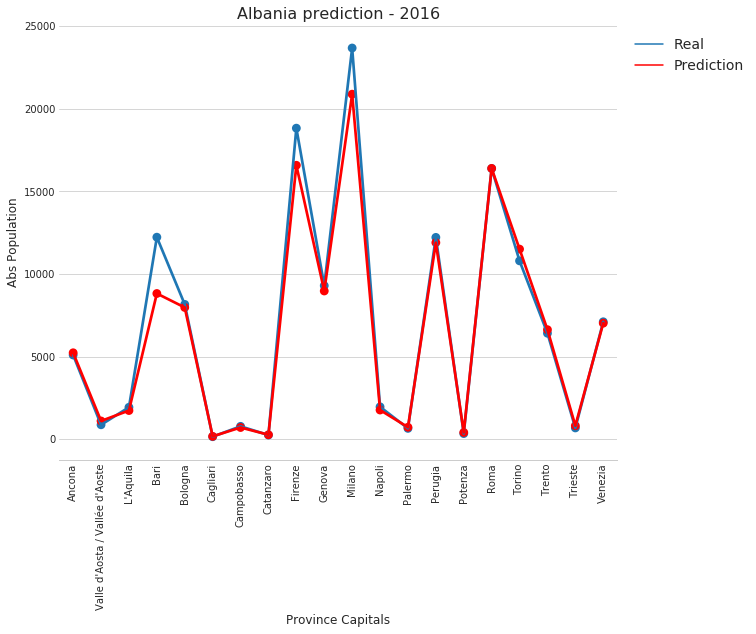

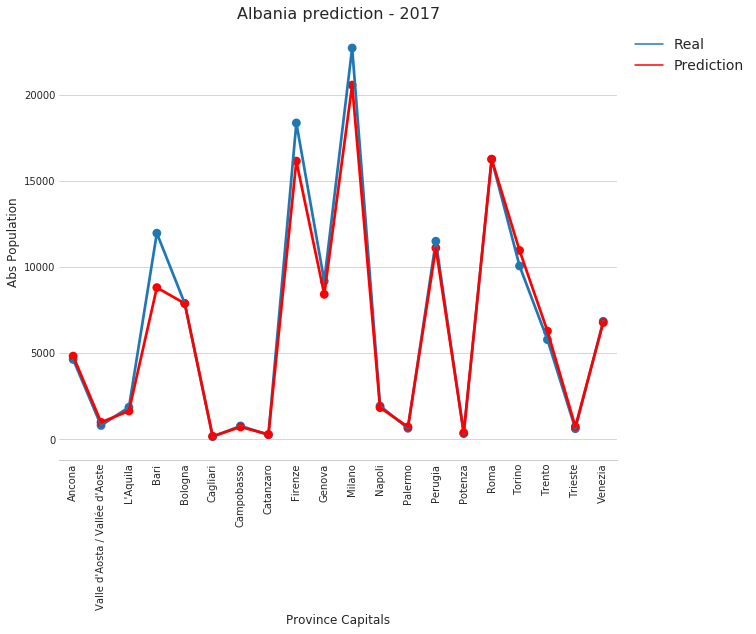

In [32]:
real_vs_prediction(res_alb, data_alb, years, x_df, "Albania")

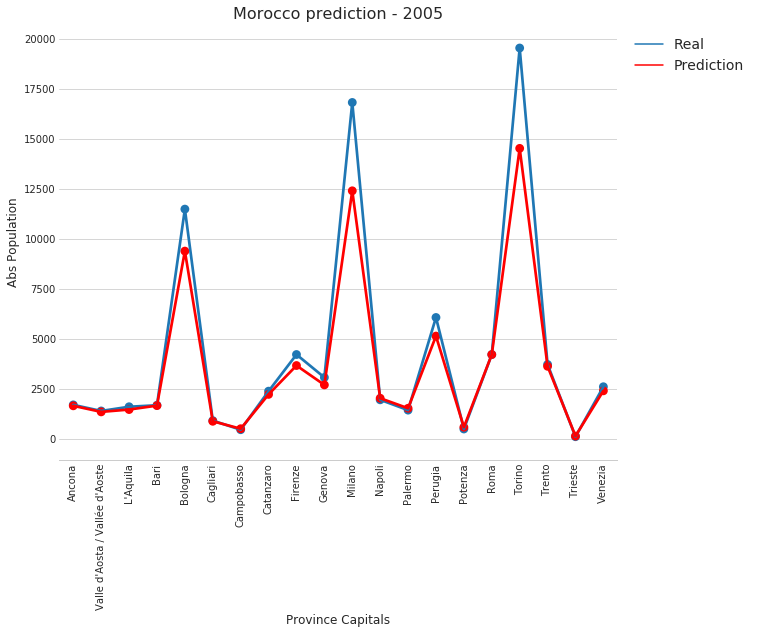

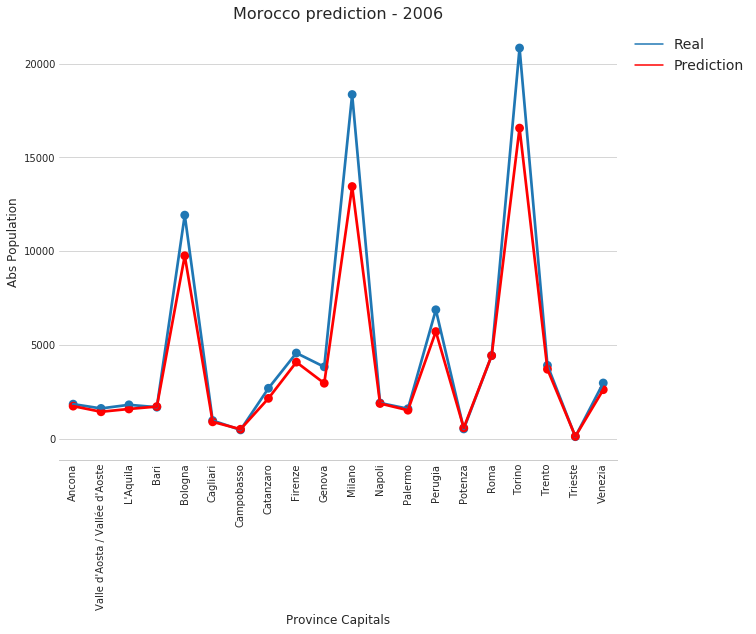

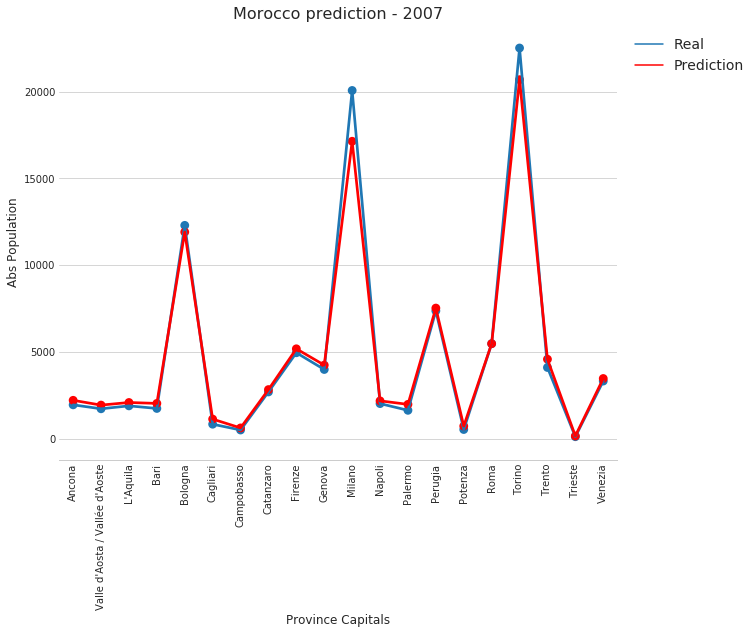

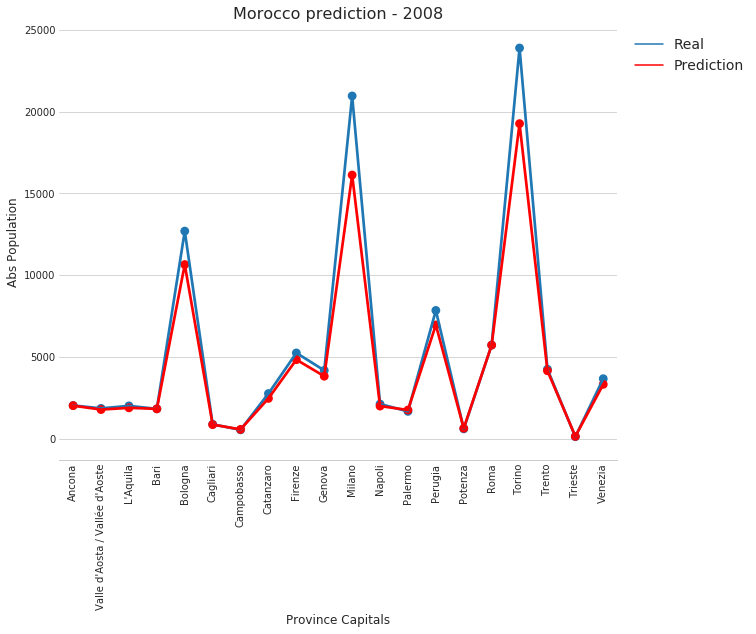

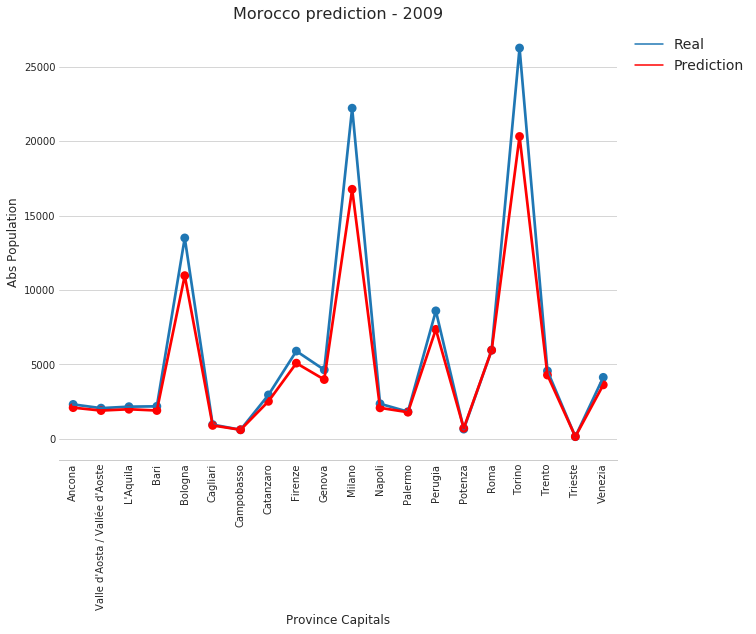

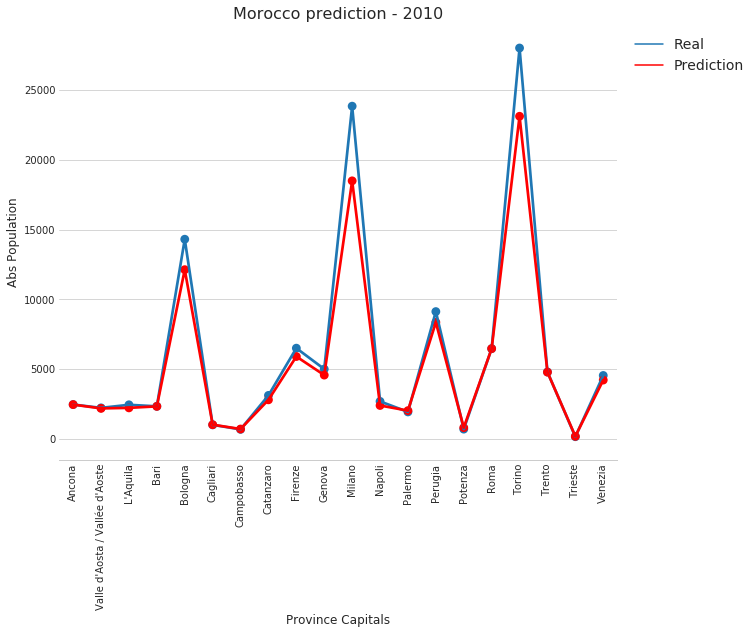

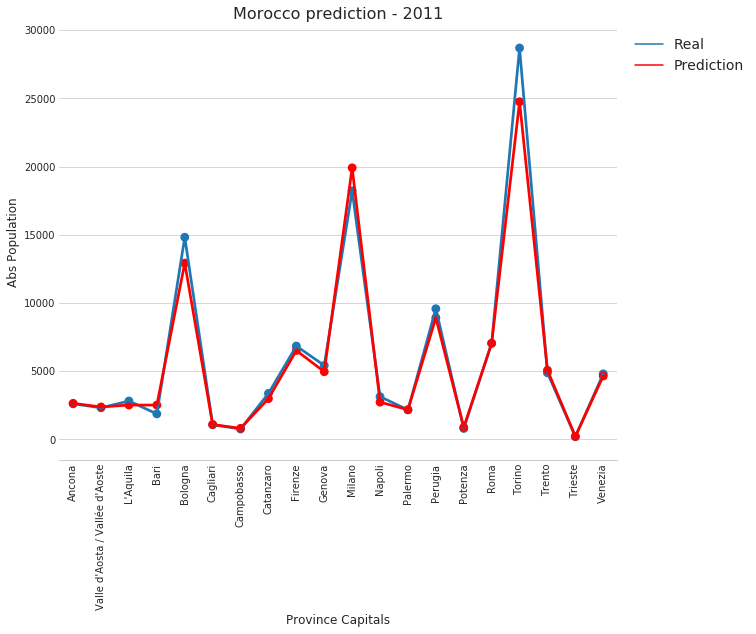

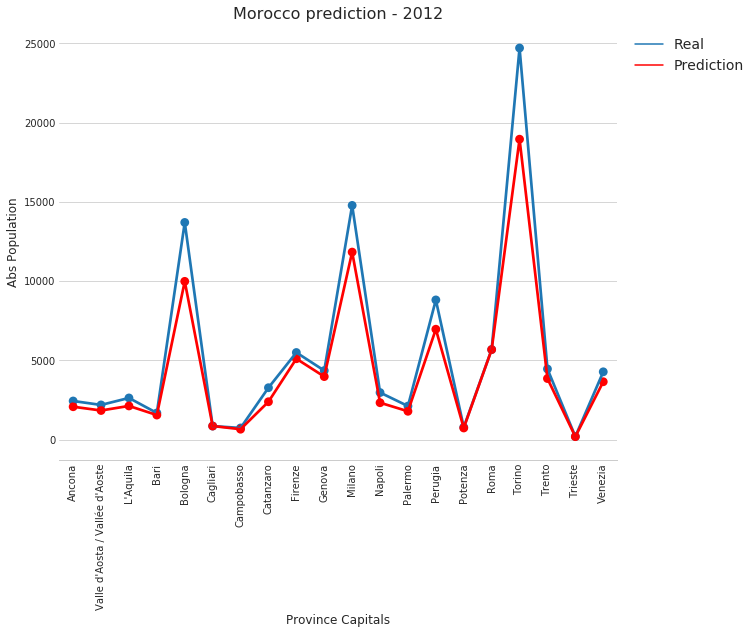

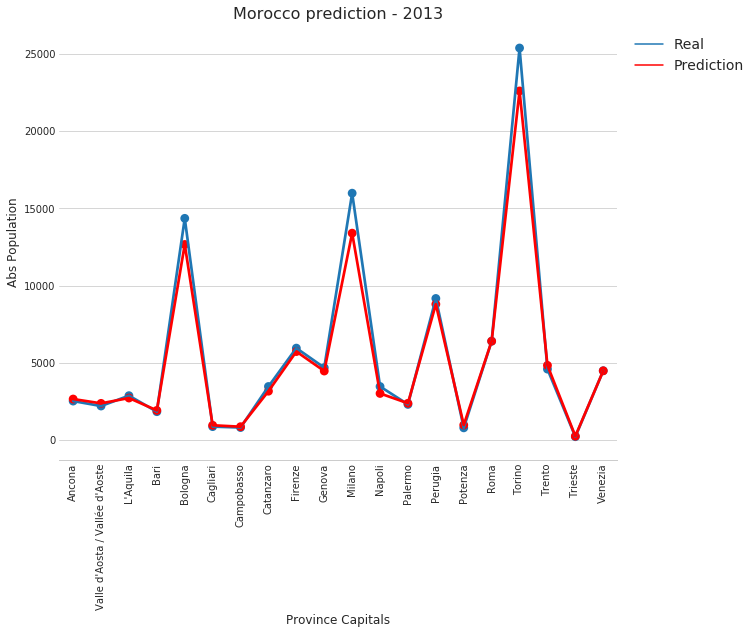

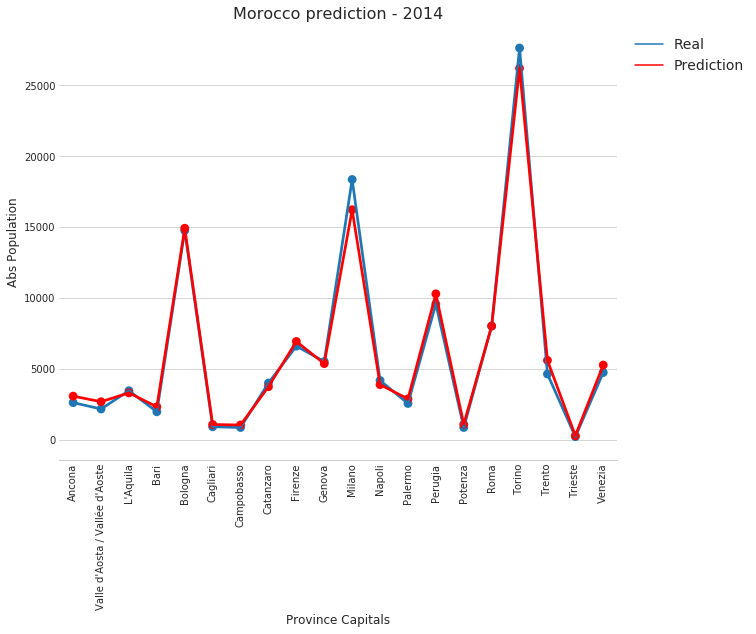

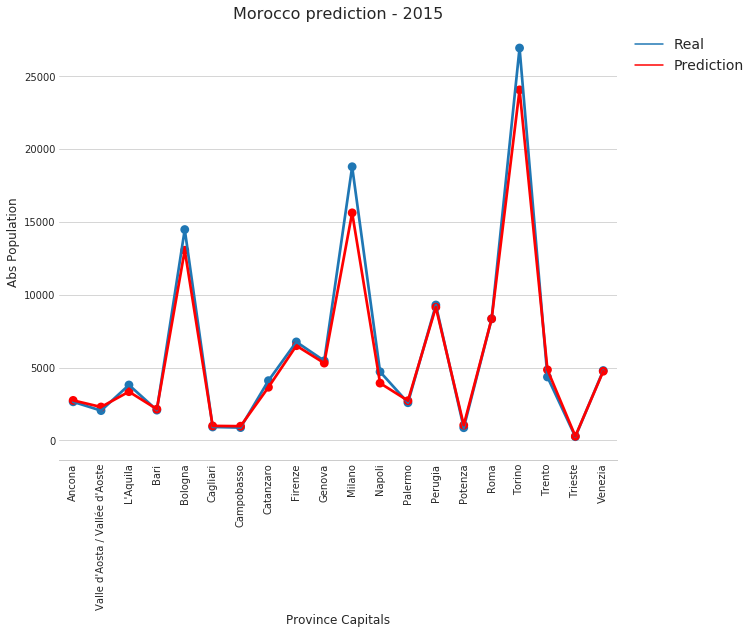

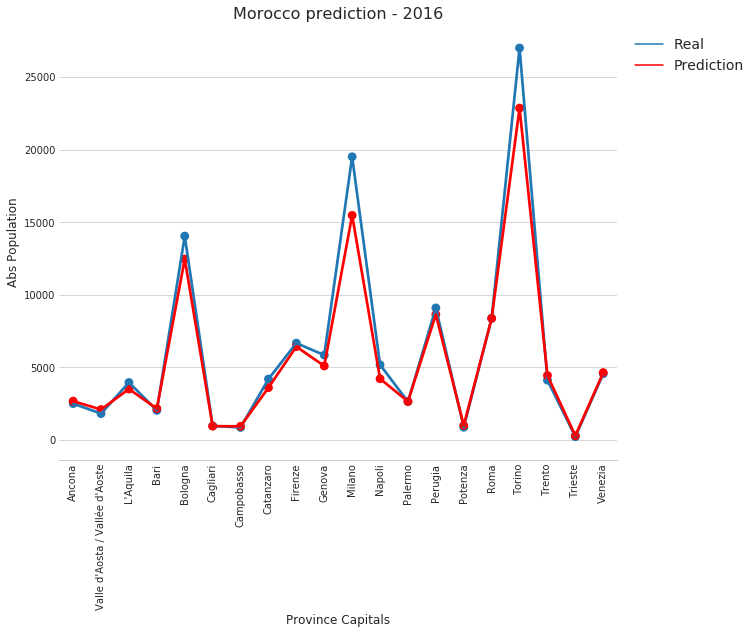

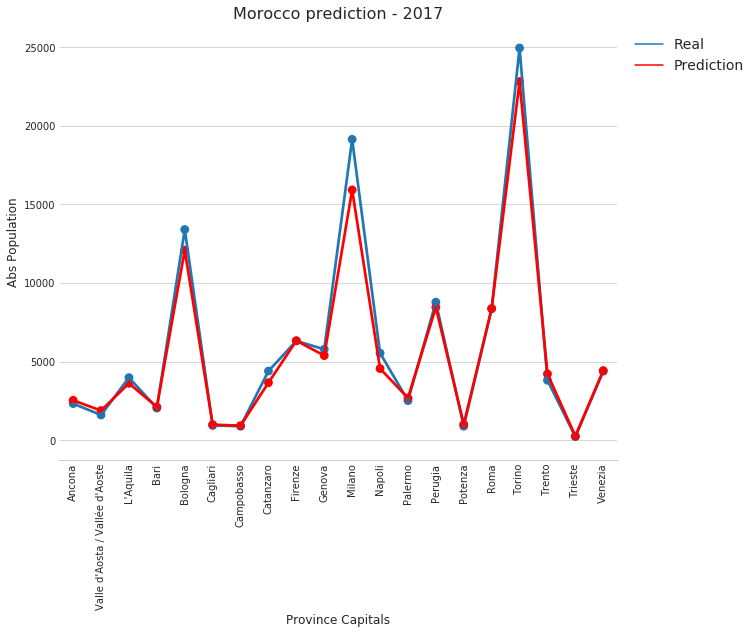

In [33]:
real_vs_prediction(res_mar, data_mar, years, x_df, "Morocco")